In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay

# Load the processed dataset
data = pd.read_csv('Desktop/laptopData_PROCESSED.csv')

# Separate features and target
X_final = data.drop(columns=['Price'])
y_final = data['Price']

# Initialize the Random Forest model
final_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42
)

# Retrain the model
final_model.fit(X_final, y_final)

print("✅ Model retrained on full dataset.")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


✅ Model retrained on full dataset.


In [2]:
# Evaluate model on full training data
y_pred = final_model.predict(X_final)

# Calculate RMSE and R^2
rmse = np.sqrt(mean_squared_error(y_final, y_pred))
r2 = r2_score(y_final, y_pred)

print(f"✅ Final Model Performance on Full Dataset:")
print(f"RMSE: {rmse:.2f}")
print(f"R^2 Score: {r2:.4f}")

✅ Final Model Performance on Full Dataset:
RMSE: 5754.86
R^2 Score: 0.9476


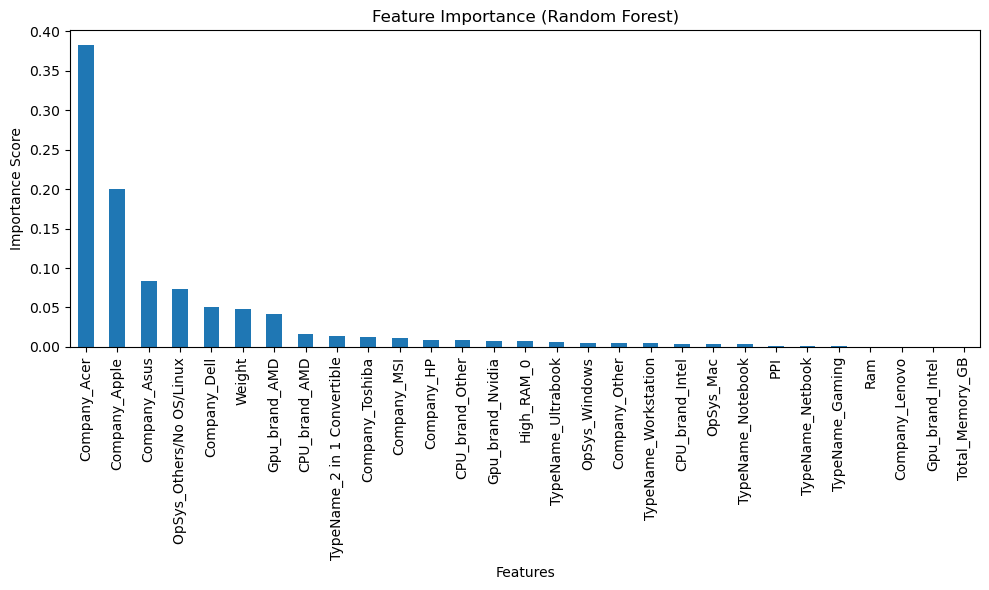

In [3]:
# Get feature importances from the trained Random Forest
importances = final_model.feature_importances_

# Match feature names
feature_names = X_final.columns

# Create a DataFrame for easy sorting
feat_importances = pd.Series(importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
feat_importances.plot(kind='bar')
plt.title('Feature Importance (Random Forest)')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.tight_layout()
plt.show()

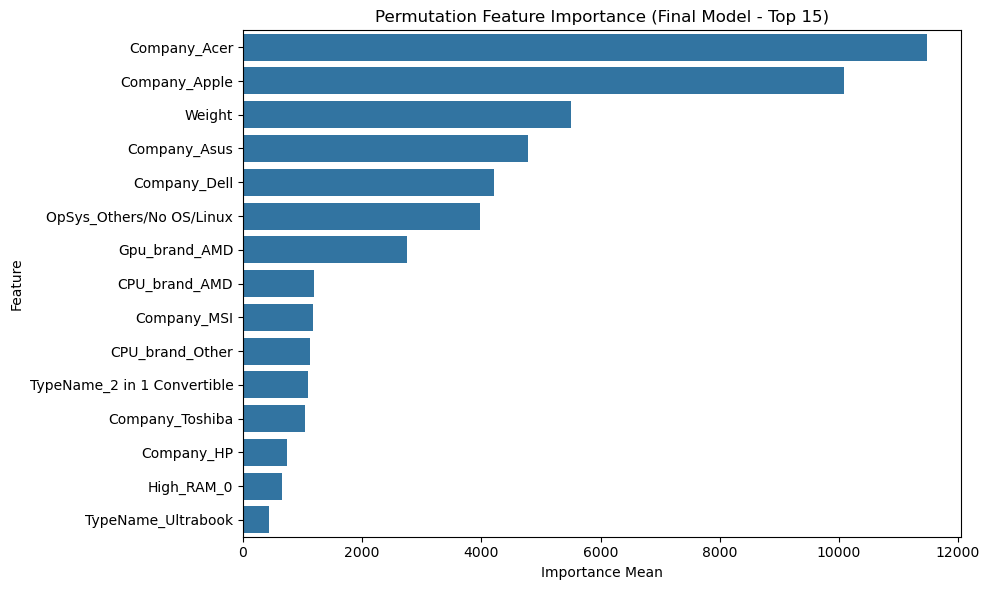

In [4]:
# Permutation importance on final_model
perm_result = permutation_importance(
    final_model,
    X_final,
    y_final,
    n_repeats=30,
    random_state=42,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

# Build a DataFrame
perm_df = pd.DataFrame({
    'Feature': X_final.columns,
    'Importance Mean': perm_result.importances_mean,
    'Importance Std': perm_result.importances_std
}).sort_values(by='Importance Mean', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance Mean', y='Feature', data=perm_df.head(15))
plt.title('Permutation Feature Importance (Final Model - Top 15)')
plt.tight_layout()
plt.show()

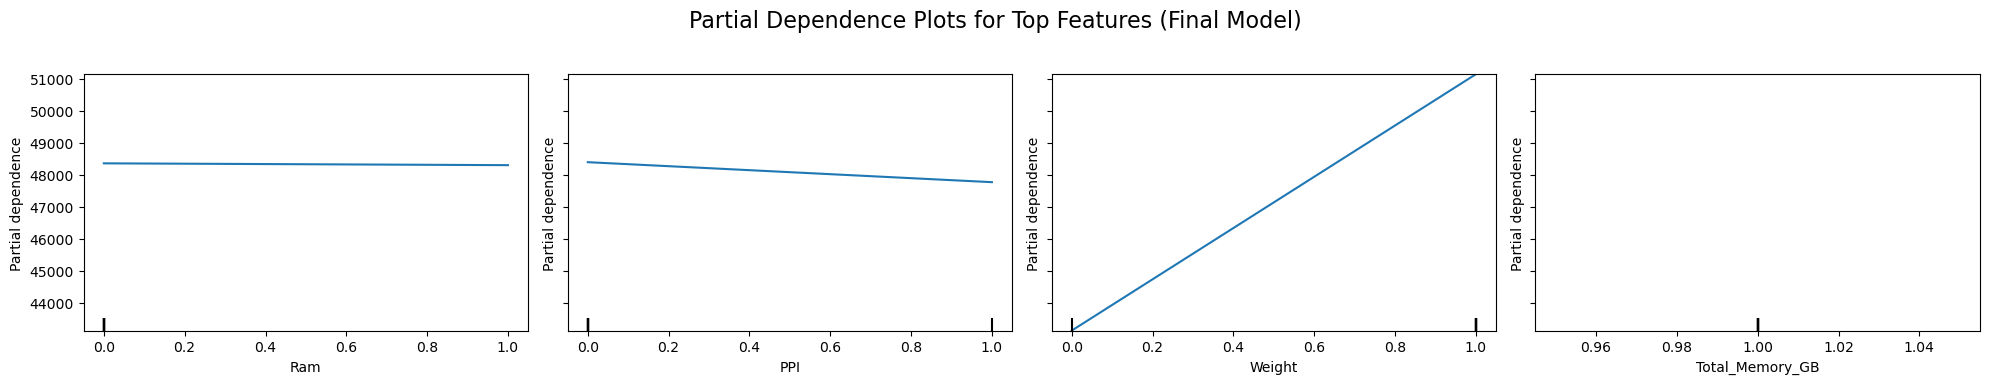

In [5]:
# Select the top features manually or from importance
top_features = ['Ram', 'PPI', 'Weight', 'Total_Memory_GB']  # example, adjust to your important ones

# Plot 1-way PDPs for top features
fig, ax = plt.subplots(ncols=len(top_features), figsize=(5 * len(top_features), 4), sharey=True)

PartialDependenceDisplay.from_estimator(
    final_model,         # ✅ retrained final model
    X_final,             # ✅ full feature set
    features=top_features,
    ax=ax,
    grid_resolution=50
)

fig.suptitle('Partial Dependence Plots for Top Features (Final Model)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

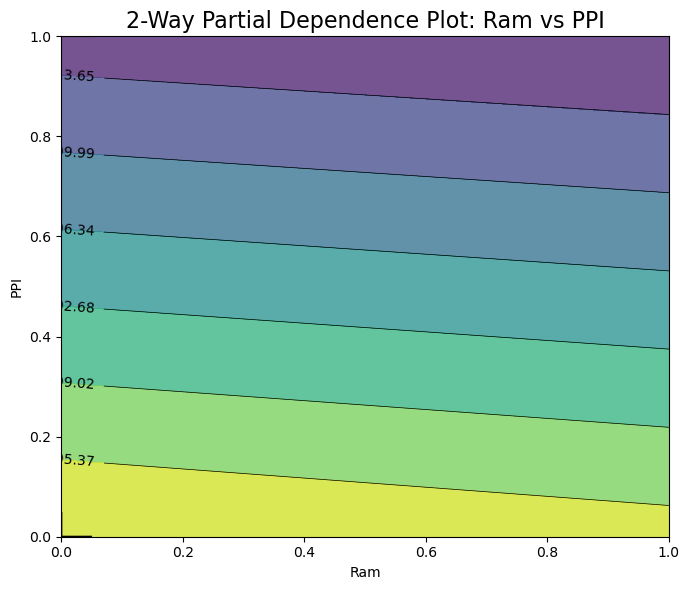

In [6]:
# Pick top 2 features
top_two_features = (top_features[0], top_features[1])  # e.g., ('Ram', 'PPI')

# Plot 2-way PDP
fig, ax = plt.subplots(figsize=(7, 6))

PartialDependenceDisplay.from_estimator(
    final_model,
    X_final,
    features=[top_two_features],   # important: wrap in list
    ax=ax,
    grid_resolution=30
)

plt.title(f'2-Way Partial Dependence Plot: {top_two_features[0]} vs {top_two_features[1]}', fontsize=16)
plt.tight_layout()
plt.show()

The figure layout has changed to tight


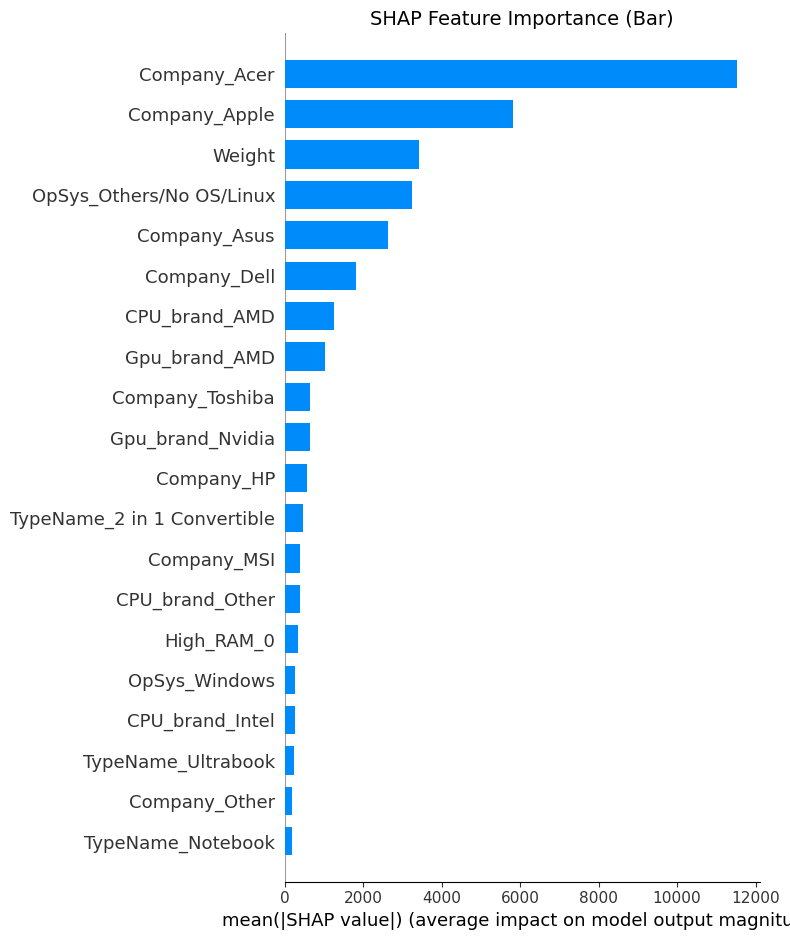

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
The figure layout has changed to tight


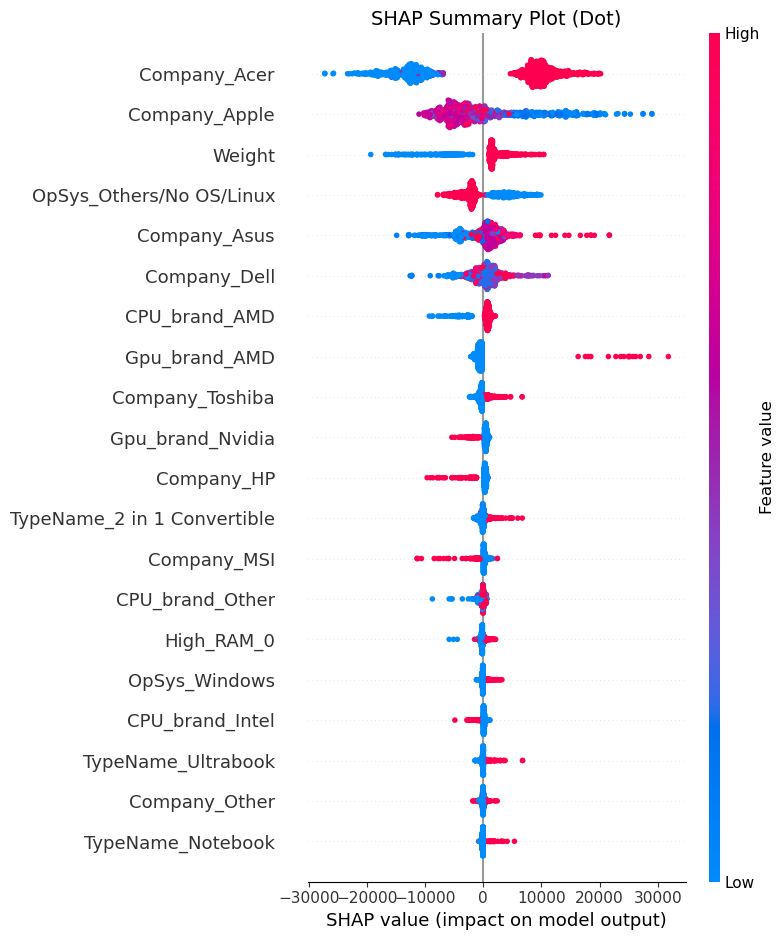

Most important feature for dependence plot: Company_Acer


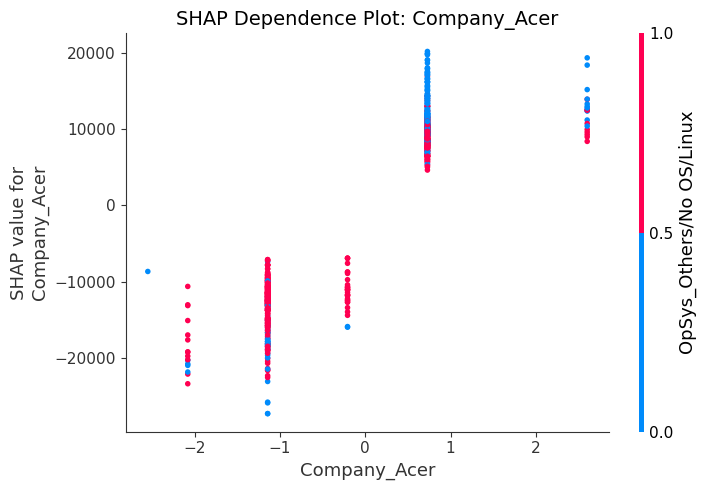

In [7]:
# Create SHAP explainer for final model
explainer = shap.TreeExplainer(final_model)

# Sample the dataset for speed
X_sample = X_final.sample(n=1000, random_state=42) if len(X_final) > 1000 else X_final

# Compute SHAP values
shap_values = explainer.shap_values(X_sample)

# If multi-output model, take the first output
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# --- SHAP SUMMARY PLOTS ---

# Bar plot
shap.summary_plot(shap_values, X_sample, plot_type='bar', show=False)
plt.title('SHAP Feature Importance (Bar)', fontsize=14)
plt.tight_layout()
plt.show()

# Beeswarm plot
shap.summary_plot(shap_values, X_sample, show=False)
plt.title('SHAP Summary Plot (Dot)', fontsize=14)
plt.tight_layout()
plt.show()

# --- SHAP DEPENDENCE PLOT ---

# Find the most important feature (based on mean absolute SHAP)
most_important = X_sample.columns[np.argsort(np.abs(shap_values).mean(axis=0))[-1]]
print(f"Most important feature for dependence plot: {most_important}")

# Plot SHAP dependence plot for that feature
shap.dependence_plot(
    most_important,
    shap_values,
    X_sample,
    interaction_index='auto',
    show=False
)
plt.title(f'SHAP Dependence Plot: {most_important}', fontsize=14)
plt.tight_layout()
plt.show()